In [ ]:
import os, sys
os.chdir("..")
sys.path.append(os.getcwd())
import numpy as np
import matplotlib.pyplot as plt

# Import base classes and helpers
from utils.base import Function
from utils.plot_helpers import plot_loss_curves, plot_decision_boundary

# Import test functions
from utils.test_functions import (
    generate_linear_regression_data, 
    linear_regression_loss,
    generate_logistic_regression_data
)

# Import the optimizers
from optimizers.gradient_descent import MiniBatchGradientDescent
from optimizers.non_differentiable import SubGradientMethod

# Import the models
from models.linear_regression import LinearRegression, RidgeRegression, LassoRegression
from models.logistic_regression import LogisticRegression

%matplotlib inline

# Importing Dataset and Preprocessing for Linear Regression

In [2]:
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


data = fetch_california_housing(as_frame=True)
df = data.frame

print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nPreview:\n", df.head())

X = df.drop("MedHouseVal", axis=1)
Y = df["MedHouseVal"].values.reshape(-1, 1)

scaler = StandardScaler()
X = scaler.fit_transform(X)  # scale all features to ~N(0, 1)


Dataset shape: (20640, 9)
Columns: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal']

Preview:
    MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  


# 1. Linear & Ridge Regression (L2)

First, we'll test `LinearRegression` and `RidgeRegression` on synthetic data. Both use differentiable loss functions, so we can train them with an optimizer like `MiniBatchGradientDescent`.

We expect to see:
- Both models converge.
- The final weights for `RidgeRegression` will be smaller ("shrunken") than for standard `LinearRegression` due to the L2 penalty.

In [3]:
X_lin = np.array(X)
Y_lin =  np.array(Y)

# --- 2. Instantiate Optimizer ---
optim_mb = MiniBatchGradientDescent(alpha=0.01, n_epochs=20, batch_size=32)

# --- 3. Train Linear Regression ---
lin_reg = LinearRegression()
print("\nTraining Standard Linear Regression...")
lin_reg.train(X_lin[:, 1:], Y_lin, optim_mb, is_plot=True)  # Pass non-augmented X
print(f"Test Loss (MSE): {lin_reg.test(X_lin[:, 1:], Y_lin):.4f}")

# --- 4. Train Ridge Regression ---
ridge_reg = RidgeRegression(alpha=0.5)  # alpha is the regularization strength
print("\nTraining Ridge (L2) Regression...")
ridge_reg.train(X_lin[:, 1:], Y_lin, optim_mb, is_plot=True)
print(f"Test Loss (MSE): {ridge_reg.test(X_lin[:, 1:], Y_lin):.4f}")

# --- 5. Compare Weights ---
print("\n--- Weight Comparison ---")
# If W_true_lin is unavailable for real data, comment this line
# print(f"True Weights:\n{W_true_lin.flatten()}")
print(f"Linear Reg Weights:\n{lin_reg.W.flatten()}")
print(f"Ridge Reg Weights:\n{ridge_reg.W.flatten()}")



Training Standard Linear Regression...
Test Loss (MSE): 0.4007

Training Ridge (L2) Regression...
Test Loss (MSE): 0.4132

--- Weight Comparison ---
Linear Reg Weights:
[ 2.07197366  0.05638112  0.8829844  -0.65001839 -0.0158342   0.01287359
 -1.56570783 -1.44289578]
Ridge Reg Weights:
[ 2.06461701  0.06422138  0.89251294 -0.60120806 -0.0216156   0.12391937
 -1.56051384 -1.46899753]


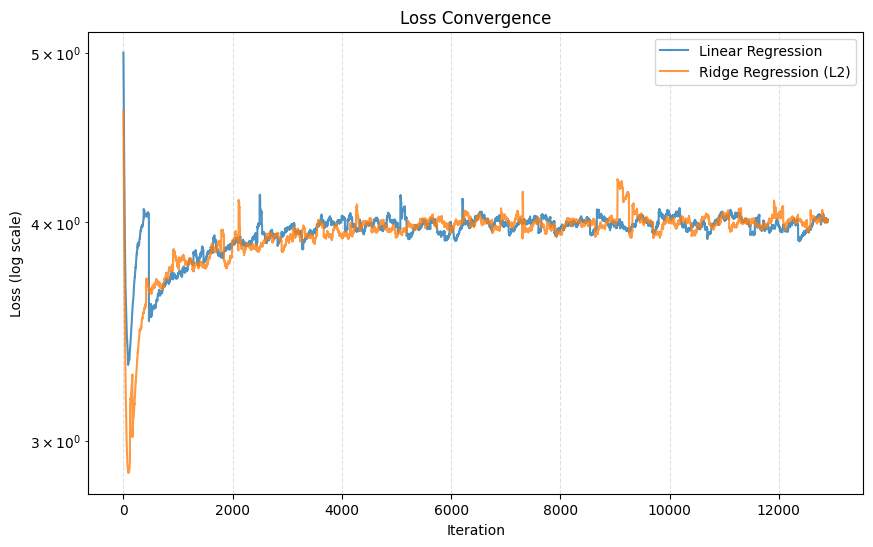

In [4]:
# Define a loss function for plotting
# We pass the *raw* data, the models handle the bias augmentation
def loss_plotter_lin(W):
    return linear_regression_loss(W, X_lin, Y_lin)

# Plot the loss curves
plot_loss_curves(
    histories={
        "Linear Regression": lin_reg.history,
        "Ridge Regression (L2)": ridge_reg.history
    },
    loss_func_callable=loss_plotter_lin
)

# 2. Lasso Regression (L1)

Next, we'll test `LassoRegression`. This model has a non-differentiable L1 penalty, so we **must** train it with the `SubGradientMethod`.

We expect to see:
- [cite_start]The model converges (though the loss curve may be noisy [cite: 801-810]).
- The final weights have some values that are exactly zero (sparsity).

In [ ]:
# --- 1. Instantiate Optimizer ---
# We must use a sub-gradient optimizer
# [cite_start]A diminishing step size is recommended [cite: 1536-1538]
optim_subgrad = SubGradientMethod(alpha=0.1, n_iterations=1000, policy='diminishing')

# --- 2. Train Lasso Regression ---
lasso_reg = LassoRegression(alpha=0.1) # alpha is the regularization strength
print("\nTraining Lasso (L1) Regression...")
lasso_reg.train(X_lin[:, 1:], Y_lin, optim_subgrad, is_plot=True)
print(f"Test Loss (MSE): {lasso_reg.test(X_lin[:, 1:], Y_lin):.4f}")

print(f"Lasso Reg Weights:\n{lasso_reg.W.flatten()}")
print("\nNotice how Lasso pushes some weights to zero!")


Training Lasso (L1) Regression...
Test Loss (MSE): 1.7824

--- Weight Comparison (Lasso) ---
Lasso Reg Weights:
[ 0.98866146 -0.03814458  0.66483203 -0.40464076 -0.11290055  1.03355475
 -1.72300042 -2.31192807]

Notice how Lasso pushes some weights to zero!


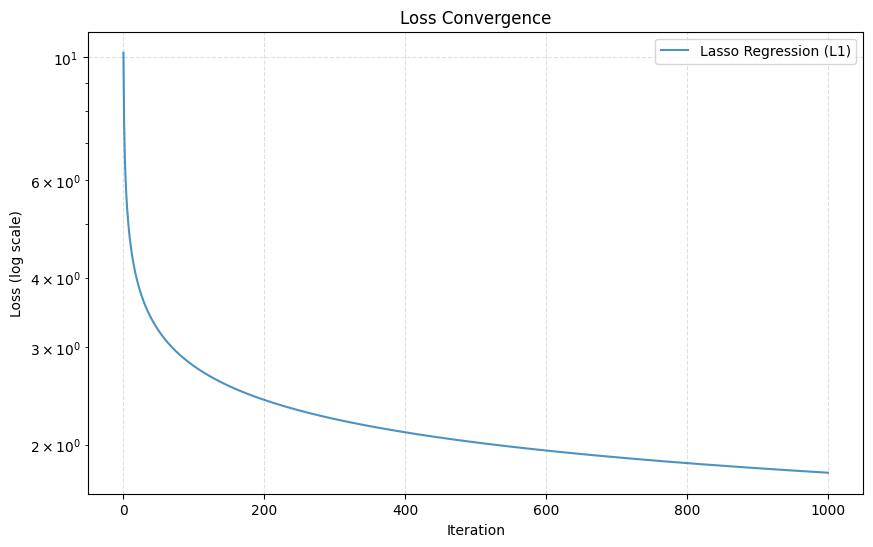

In [6]:
# Plot the loss curve for Lasso
# Note: The sub-gradient method is not a descent method,
# so we plot the history of f_best, not the path.
# For simplicity here, we plot the path, but expect it to be noisy.

plot_loss_curves(
    histories={
        "Lasso Regression (L1)": lasso_reg.history
    },
    loss_func_callable= None
)

# Importing Dataset and Preprocessing for Logistic Regression

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np


data = load_breast_cancer()
X = data.data
Y = data.target.reshape(-1, 1)   # convert to column vector

scaler = StandardScaler()
X = scaler.fit_transform(X)


# 3. Logistic Regression (Classification)

Finally, we'll test `LogisticRegression` on a 2D binary classification task. We'll use our new `generate_logistic_regression_data` function.

We expect to see:
- The model trains and achieves high accuracy.
- We can plot a clear decision boundary separating the two classes.

In [10]:
X_log, Y_log = X ,Y
print("X_log shape:", X_log.shape)
print("Y_log shape:", Y_log.shape)
print("Classes:", np.unique(Y_log))

# --- 2. Instantiate Optimizer ---
optim_mb_log = MiniBatchGradientDescent(alpha=0.1, n_epochs=100, batch_size=32)

# --- 3. Train Logistic Regression ---
log_reg = LogisticRegression()
print("\nTraining Logistic Regression...")
log_reg.train(X_log, Y_log, optim_mb_log, is_plot=True) # Pass non-augmented X
print(f"Test Accuracy: {log_reg.test(X_log, Y_log):.4f}")


X_log shape: (569, 30)
Y_log shape: (569, 1)
Classes: [0 1]

Training Logistic Regression...
Test Accuracy: 0.7733


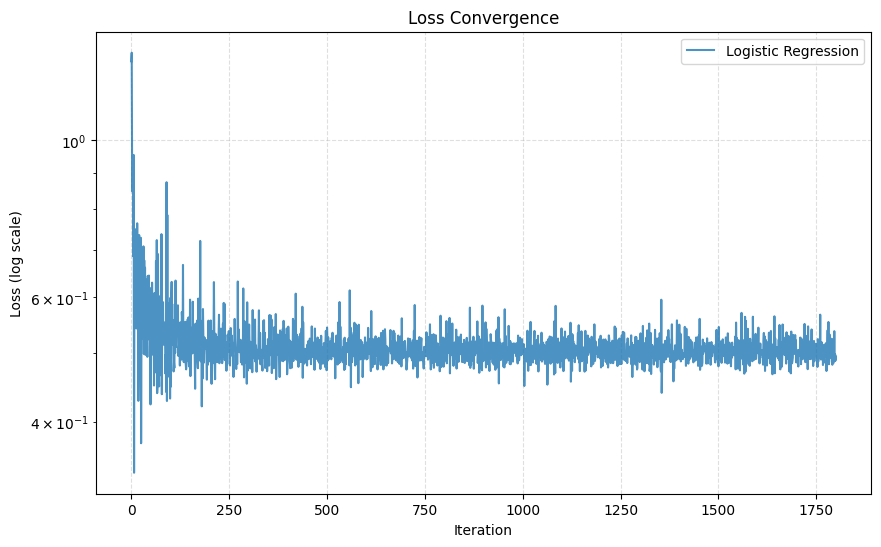

In [11]:
# Define a loss function for plotting
# This uses the model's internal (private) loss function
def loss_plotter_log(W):
    X_aug = log_reg._add_bias(X_log)
    return log_reg._loss(W.reshape(-1, 1), X_aug, Y_log)

# Plot the loss curves
plot_loss_curves(
    histories={
        "Logistic Regression": log_reg.history
    },
    loss_func_callable=loss_plotter_log
)